## Trabalho 1
#### A partir do material visto nas aulas, criar um ou mais algoritmos que investem de forma eficiente (maior retorno, menor risco, maior relação retorno/risco) nos seguintes índices e taxas: 

- IBOVESPA
- SELIC
- IMA-B (Tesouro IPCA)
- OURO
- USDBRL (Dólar)
- SP500BRL (S&P 500 em R$) 

In [18]:
import pandas as pd
import datetime
import numpy as np
import pdb
import plotly.graph_objects as go
import scipy.optimize as sc


import matplotlib.pyplot as plt

In [24]:
## This code downloads the data file to local execution

# File Service
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
from googleapiclient.http import MediaIoBaseDownload
import io
import os

def download_file_by_id(file_id, file_path, drive_service):
  file_service = drive_service.files()
  file_name = file_service.get(fileId=file_id, fields="name", supportsAllDrives=True).execute()['name']
  request = drive_service.files().get_media(fileId=file_id, supportsAllDrives=True)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()

  downloaded.seek(0)
  content = downloaded.read()

  file_path = os.path.join(file_path, file_name)

  print("Downloading %s to %s"%(file_name, file_path))
  with open(file_path, "wb") as file:
    file.write(content)

  return file_path

if not os.path.exists("content/data"):
  os.makedirs("content/data")

file_path = download_file_by_id("1eMba4gnU5tndWZMiPcp0_NrLupsWHs7u", "content/data", drive_service)

In [3]:
file_path = "content/data/Dados-Trabalho-2004-2015.xlsx"
df = pd.read_excel(file_path)

def format_data(data):
  month = data.split("-")[0]
  year = int(data.split("-")[1])
  months = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"]
  month = months.index(month) + 1
  return datetime.datetime(year, month, 1)

df["Data"] = df["Data"].apply(format_data)
df.set_index("Data", inplace=True)

df

,IBOV,USDBRL,OURO,SELIC,IMAB,SP500BRL
Data,,,,,,
2003-12-01,22236,2.8892,38.600,1031.614995,811.970067,3212.559264
2004-01-01,21851,2.9409,37.900,1044.691245,859.640824,3326.481399
2004-02-01,21755,2.9138,37.000,1056.019816,872.124846,3336.126172
2004-03-01,22142,2.9086,39.300,1070.583633,884.873768,3275.694406
2004-04-01,19607,2.9447,36.400,1083.236327,893.734774,3260.666310
...,...,...,...,...,...,...
2015-08-01,46625,3.6467,131.500,3930.226450,3735.785498,7191.948806
2015-09-01,45059,3.9729,141.000,3973.811230,3710.203522,7628.087187
2015-10-01,45868,3.8589,140.250,4017.879360,3805.753621,8024.042304


<AxesSubplot:xlabel='Data'>

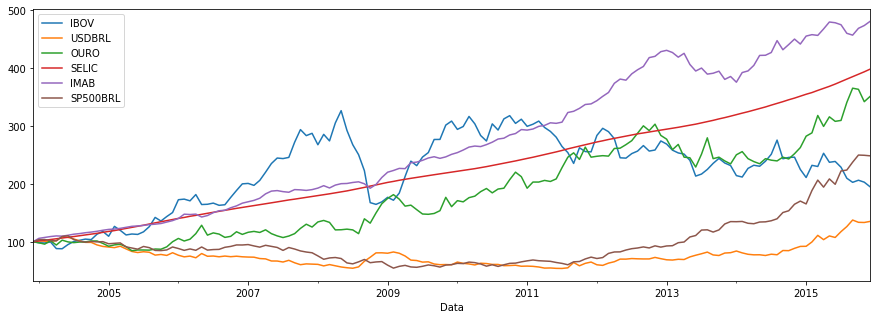

In [4]:
normalized = df.copy()

for col in df.columns:
  normalized[col] = normalized[col] * 100 / normalized[col].iloc[0]

normalized.plot(figsize = (15,5))


In [5]:
def calc_ret_vol(assets, weights):
  """
    Gets annualized returns and vol
  """
  years = normalized.index.year.unique()

  port = assets.dot(weights)
  port_chg = port.pct_change()
  port_chg = port_chg.fillna(0)
  ret = ((port.iloc[-1]/port.iloc[0])**(1/len(years)))-1
  vol = port_chg.std()*np.sqrt(252)
  return ret, vol

In [6]:
#Portfolio com 2 ativos

points = [] 
min_vol_ret = [100, 0] #[vol, ret]
weights = [0, 0, 0, 0, 0, 0]
for w in range(0, 101, 5):
  ret, vol = calc_ret_vol(normalized, [0, 0, 0, w/100, (1-w/100), 0])
  print("Aloc:", round(w/100, 2), round(1-(w/100),2), "Ret:", round(ret, 3), "Vol:", round(vol, 3)) 
  points.append([ret, vol])
  if vol < min_vol_ret[0]:
    min_vol_ret[0] = vol
    min_vol_ret[1] = ret
    weights[3] = w/100
    weights[4] = 1-w/100

Aloc: 0.0 1.0 Ret: 0.128 Vol: 0.296
Aloc: 0.05 0.95 Ret: 0.128 Vol: 0.284
Aloc: 0.1 0.9 Ret: 0.127 Vol: 0.271
Aloc: 0.15 0.85 Ret: 0.126 Vol: 0.258
Aloc: 0.2 0.8 Ret: 0.125 Vol: 0.245
Aloc: 0.25 0.75 Ret: 0.125 Vol: 0.231
Aloc: 0.3 0.7 Ret: 0.124 Vol: 0.218
Aloc: 0.35 0.65 Ret: 0.123 Vol: 0.204
Aloc: 0.4 0.6 Ret: 0.122 Vol: 0.191
Aloc: 0.45 0.55 Ret: 0.121 Vol: 0.177
Aloc: 0.5 0.5 Ret: 0.121 Vol: 0.163
Aloc: 0.55 0.45 Ret: 0.12 Vol: 0.149
Aloc: 0.6 0.4 Ret: 0.119 Vol: 0.134
Aloc: 0.65 0.35 Ret: 0.118 Vol: 0.12
Aloc: 0.7 0.3 Ret: 0.117 Vol: 0.106
Aloc: 0.75 0.25 Ret: 0.116 Vol: 0.092
Aloc: 0.8 0.2 Ret: 0.116 Vol: 0.078
Aloc: 0.85 0.15 Ret: 0.115 Vol: 0.065
Aloc: 0.9 0.1 Ret: 0.114 Vol: 0.053
Aloc: 0.95 0.05 Ret: 0.113 Vol: 0.045
Aloc: 1.0 0.0 Ret: 0.112 Vol: 0.042


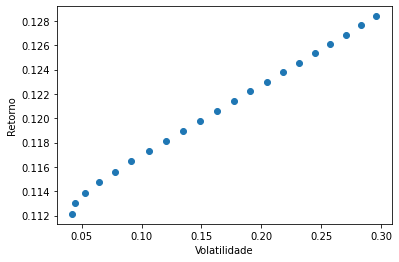

In [7]:
lp = np.array(points).T
plt.scatter(lp[[1][:]],lp[[0][:]]);
plt.ylabel("Retorno");
plt.xlabel("Volatilidade");

years = normalized.index.year.unique()

# vol_aa = normalized.pct_change().std()*np.sqrt(252)
# ret_aa = ((normalized.iloc[-1]/normalized.iloc[0])**(1/len(years)))-1

# plt.scatter(vol_aa['GUAR3.SA'], ret_aa['GUAR3.SA'], color='red');
# plt.text(vol_aa['GUAR3.SA'], ret_aa['GUAR3.SA'], 'GUAR3');

# plt.scatter(vol_aa['JBSS3.SA'], ret_aa['JBSS3.SA'], color='red');
# plt.text(vol_aa['JBSS3.SA'], ret_aa['JBSS3.SA'], 'JBSS3');

# plt.scatter(min_vol_ret[0], min_vol_ret[1], color='green');
# plt.text(min_vol_ret[0], min_vol_ret[1], 'Min. Vol.');

845.5657492354741
['nothing', 'nothing', 'buy', 'sell', 'nothing', 'buy', 'nothing', 'nothing', 'nothing', 'sell', 'buy', 'nothing', 'sell', 'buy', 'sell', 'nothing', 'buy', 'sell', 'buy', 'nothing', 'nothing', 'sell', 'buy', 'nothing', 'nothing', 'nothing', 'sell', 'buy', 'sell', 'buy', 'nothing', 'sell', 'buy', 'nothing', 'nothing', 'nothing', 'nothing', 'sell', 'buy', 'nothing', 'nothing', 'nothing', 'sell', 'buy', 'nothing', 'nothing', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'nothing', 'sell', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'buy', 'nothing', 'sell', 'buy', 'nothing', 'nothing', 'sell', 'buy', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'sell', 'buy', 'nothing', 'sell', 'nothing', 'nothing', 'buy', 'sell', 'buy', 'nothing', 'sell', 'buy', 'sell', 'buy', 'nothing', 'sell', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'buy', 'sell', 'nothing', 'buy', 'nothing', 'sell', 'nothing', 'nothing', 'nothing', 'buy', 'nothing', 'nothing', 'sell

<AxesSubplot:xlabel='Date'>

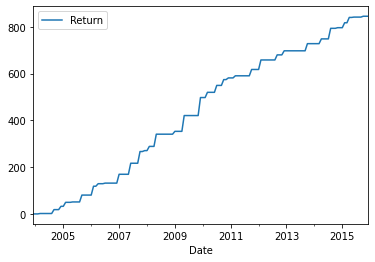

In [17]:
def get_hash(op, period, price_paid):
  return "%s_%d_%.2f"%(op, period, price_paid)

class Solver():
  def __init__(self):
    self.memo = {}
    self.total_access = 0

  def get_memo(self, hash):
    self.total_access += 1
    return self.memo[hash]

  def recursive(self, data, period = 0, price_paid = -1):
    possibilities = []
    paths = []

    hash_buy = get_hash("buy", period, price_paid)
    hash_sell = get_hash("sell", period, price_paid)
    hash_nothing = get_hash("nothing", period, price_paid)

    hashs = {
      "buy": hash_buy,
      "sell": hash_sell,
      "nothing": hash_nothing
    }

    current_price = data.iloc[period]

    def do_move(move, period, price, profit = 0):
      hash = hashs[move]
      value = 0
      path = []
      if hash not in self.memo:
        value, path = self.recursive(data, period, price)
        self.memo[hash] = [value, path]
      else:
        value, path = self.get_memo(hash)

      value += profit

      possibilities.append(value)
      paths.append([move] + path)
    
    if period == data.shape[0] - 1: # last period
      if price_paid >= 0:
        profit = current_price - price_paid # selling
        return profit, ["sell"]
      else:
        return 0, ["nothing"]

    if period == 0: # first period
      do_move("buy", 1, current_price)
      do_move("nothing", 1, -1)

    if price_paid >= 0: # have bought
      profit = current_price - price_paid
      do_move("sell", period +1, -1, profit)

    else:
      do_move("buy", period + 1, current_price)

    do_move("nothing", period + 1, price_paid)

    max_possibility = max(possibilities)
    max_index = possibilities.index(max_possibility)
    max_path = paths[max_index]

    return max_possibility, max_path

def run_path(data, path):
  df = []
  curr_profit = 0
  paid_price = -1

  for i, move in enumerate(path):
    date = data.index[i]
    current_price = data.iloc[i]

    if move == "sell":
      profit = current_price - paid_price
      paid_price = -1
      curr_profit += profit
    
    elif move == "buy":
      paid_price = current_price

    df += [[date, curr_profit]]

  df = pd.DataFrame(df, columns = ["Date", "Return"])
  return df.set_index("Date")

def best_possible_outcome(data):
  # pdb.set_trace()
  solver = Solver()
  value, path = solver.recursive(data)
  print(value)
  print(path)
  print(solver.total_access)

  return path

path = best_possible_outcome(normalized["IBOV"])
df_path = run_path(normalized["IBOV"], path)
df_path.plot()

In [53]:
normalized["IBOV"].iloc[:5]


Data
2003-12-01    100.000000
2004-01-01     98.268573
2004-02-01     97.836841
2004-03-01     99.577262
2004-04-01     88.176830
Name: IBOV, dtype: float64

In [19]:
class EfficientFrontier():
  def __init__(self, df, risk_free_rate = 0.05):
    self.df = df
    self.weights = np.array([1.0/len(df.columns)] * len(df.columns)) # equal weights
    self.risk_free_rate = risk_free_rate

  def calc(self):
    mean_returns = self.get_mean_returns()
    cov_matrix = self.get_cov_matrix()

    returns, std = self.portfolio_performance(self.weights, mean_returns, cov_matrix)
    returns, std = round(returns*100, 2), round(std*100, 2)

    self.ef_graph(mean_returns, cov_matrix, returns, std)

  def get_mean_returns(self):
    returns = self.df.pct_change()
    mean_returns = returns.mean()
    return mean_returns

  def get_cov_matrix(self):
    returns = self.df.pct_change()
    cov_matrix = returns.cov()
    return cov_matrix

  def portfolio_performance(self, weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*self.df.shape[0]
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(self.df.shape[0])

    return returns, std

  def ef_graph(self, mean_returns, cov_matrix, returns, std,):
    max_sr_returns, max_sr_std, max_sr_allocation, min_vol_returns, min_vol_std, min_vol_allocation, efficient_list, target_returns \
      = self.calculated_results(mean_returns, cov_matrix)

    max_sharpe_ratio = go.Scatter(
        name='Maximum Sharpe Ratio',
        mode='markers',
        x=[max_sr_std],
        y=[max_sr_returns],
        marker=dict(color='red', size=14, line=dict(width=3, color='black'))
    )

    print(max_sr_allocation)
    print(min_vol_allocation)

    min_vol_ratio = go.Scatter(
        name='Minimum Volatility',
        mode='markers',
        x=[min_vol_std],
        y=[min_vol_returns],
        marker=dict(color='green', size=14, line=dict(width=3, color='black'))
    )

    ef_curve = go.Scatter(
        name='Efficient Frontier',
        mode='lines',
        x=[round(ef_std*100, 2) for ef_std in efficient_list],
        y=[round(target*100, 2) for target in target_returns],
        line=dict(color='black', width=4, dash='dashdot')
    )

    data = [max_sharpe_ratio, min_vol_ratio, ef_curve]
    layout = go.Layout(
        title = 'Portfolio optitmisation',
        yaxis = dict(title='Annualised Return (%)'),
        xaxis = dict(title= 'Annualised Volatility (%)'),
        showlegend = True,
        legend = dict(
            x = 0.75, y = 0, traceorder = 'normal',
            bgcolor='#e2e2e2',
            bordercolor='black',
            borderwidth=2
        ),
        width=800,
        height=600
    )
    fig = go.Figure(data=data, layout=layout)

    return fig.show()


  def calculated_results(self, mean_returns, cov_matrix):
    max_sr_returns, max_sr_std, max_sr_allocation = self.get_results(self.maximize_sr, mean_returns, cov_matrix)
    min_vol_returns, min_vol_std, min_vol_allocation = self.get_results(self.minimize_variance, mean_returns, cov_matrix)

    target_returns = np.linspace(min_vol_returns, max_sr_returns, 20)
    efficient_list = []
    for target in target_returns:
        efficient_list.append(self.efficient_optimization(mean_returns, cov_matrix, target)['fun'])

    max_sr_returns, max_sr_std = round(max_sr_returns*100, 2), round(max_sr_std*100, 2)
    min_vol_returns, min_vol_std = round(min_vol_returns*100, 2), round(min_vol_std*100, 2)

    return max_sr_returns, max_sr_std, max_sr_allocation, min_vol_returns, min_vol_std, min_vol_allocation, efficient_list, target_returns

  def efficient_optimization(self, mean_returns, cov_matrix, return_target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = (
        {'type': 'eq', 'fun': lambda x: self.portfolio_return(x, mean_returns, cov_matrix) - return_target},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    )
    bound = (0, 1)
    bounds = tuple(bound for asset in range(num_assets))
    eff_opt = sc.minimize(self.portfolio_variance, num_assets*[1./num_assets], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return eff_opt

  def get_results(self, func, mean_returns, cov_matrix):
    portfolio = func(mean_returns, cov_matrix)
    returns, std = self.portfolio_performance(portfolio['x'], mean_returns, cov_matrix)
    allocation = pd.DataFrame(portfolio['x'], index = mean_returns.index, columns=['allocation'])
    return returns, std, allocation

  def negative_sr(self, weights, mean_returns, cov_matrix):
    p_returns, p_std = self.portfolio_performance(weights, mean_returns, cov_matrix)
    return - (p_returns - self.risk_free_rate)/p_std

  def portfolio_variance(self, weights, mean_returns, cov_matrix):
    return self.portfolio_performance(weights, mean_returns, cov_matrix)[1]

  def portfolio_return(self, weights, mean_returns, cov_matrix):
    return self.portfolio_performance(weights, mean_returns, cov_matrix)[0]

  def maximize_sr(self, mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0, 1)
    bounds = tuple(bound for asset in range(num_assets))
    result = sc.minimize(self.negative_sr, num_assets*[1./num_assets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

  def minimize_variance(self, mean_returns, cov_matrix,):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0, 1)
    bounds = tuple(bound for asset in range(num_assets))
    result = sc.minimize(self.portfolio_variance, num_assets*[1./num_assets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result 



In [20]:
efficient_frontier = EfficientFrontier(normalized, 0.05)
efficient_frontier.calc()

          allocation
IBOV        0.000000
USDBRL      0.000000
OURO        0.000000
SELIC       0.974238
IMAB        0.014153
SP500BRL    0.011610
            allocation
IBOV      0.000000e+00
USDBRL    4.192472e-18
OURO      0.000000e+00
SELIC     9.760816e-01
IMAB      1.175961e-02
SP500BRL  1.215877e-02
